In [37]:
# importing moudles
# and using some magic to autoreload them if changed
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('./nonlin')
sys.path.append('./partion')
sys.path.append('./Probs')

from aspen import aspen
from newton import newton

import partion as pt
import wrapper as wp

from hb import transfer
from fix_bd_1D import fxbd_1D
import numpy as np
import matplotlib.pyplot as plt

test = wp.test_decorator(wp.test)
plt.style.use('default')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
# model to be studied
def model(u):
    return np.array([np.tanh(u)+1, 1/np.cosh(u)**2])

#x_t = np.linspace(0, 1)
#plt.plot(x_t, np.tanh(x_t))

In [39]:
class Coef():
    def __init__(self, Nx, Amp=0, Period=0, Scale=1, model=None):
        self.val = np.zeros((Nx, 1))
        for i in range(Nx):
            self.val[i] = (
                Amp * np.sin(Period * 2*np.pi * (i+1) / (Nx+1)) + 1) * Scale
        self.model = model

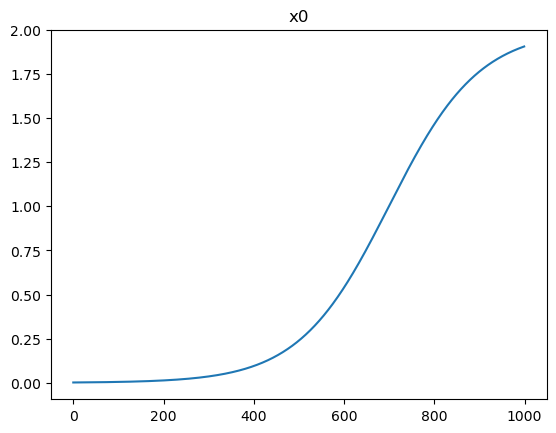

In [56]:
Nx = 1000
Nt = 10
param ={'Nx': Nx, 'Nt' : Nt}
x = np.linspace(0, 1, Nx)
C = Coef(Nx, 0.5, 1, 1.2e-1, model=model)
x0 = (np.tanh((x-0.7)*5)+1)
#x0 = (1+0.8*np.sin(4*x*np.pi/2))*x
x0 = x0.reshape(-1, 1)
bd1 = x0[0]
bd2 = x0[-1]
plt.title('x0')
plt.plot(x0)
plt.show()

In [74]:
prob = transfer(C, param)
solver_n = fxbd_1D(param, prob)
solver_n.setBoundary(bd1, bd2)
nl_solver = newton(crit_abs = 1e-10)
solver_n.setSolver(nl_solver)

In [75]:
solver_n.setInitial(x0)
X, mes, t_new, delta_new = test(solver_n, sample_size = 4)

test started
verdict : OK
time : 2.031 +- 0.1948
mean newton iterations:  3.0


In [76]:
cost_new = solver_n.timelog.kn*Nx*(c_r+c_j+c_l)+c_r*Nx

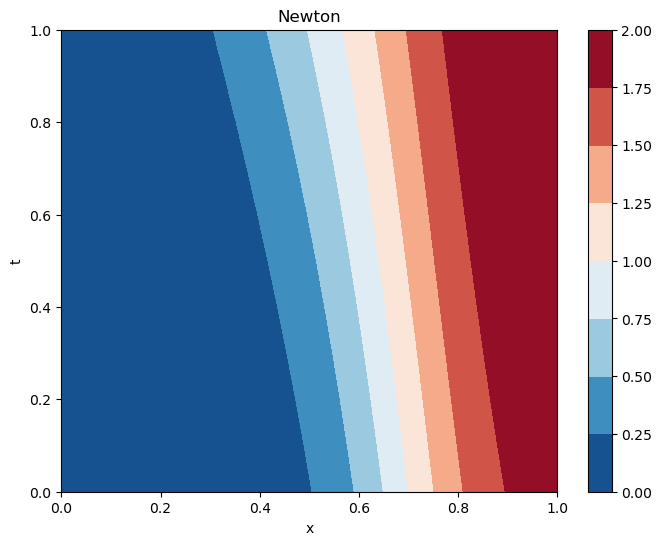

In [59]:
wp.show_res(solver_n)

In [77]:
prob = transfer(C, param)
solver = fxbd_1D(param, prob)
solver.setBoundary(bd1, bd2)
solver.setInitial(x0)
Nd = 4
partion = pt.partion_equally(Nx, Nd)
nl_solver = aspen(Nd, partion, crit_abs=1e-10)
solver.setSolver(nl_solver)

In [78]:
X, mes, t_eq, delta_eq = test(solver, sample_size=4)

test started
verdict : OK
time : 4.207 +- 0.4853
mean aspen iterations:  3.0


In [79]:
cost_eq = Nx*( (c_r+c_l)*solver.timelog.aspen_iters+c_r
    + np.mean(solver.timelog.domain_iters, axis = 0)*(c_r+c_l+c_j))

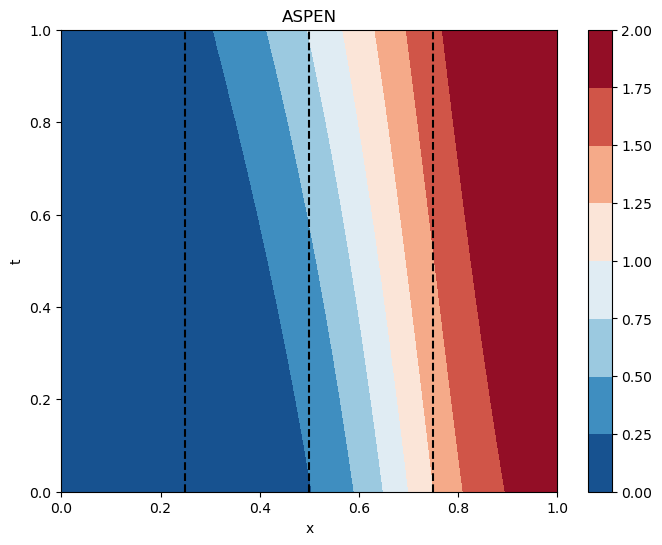

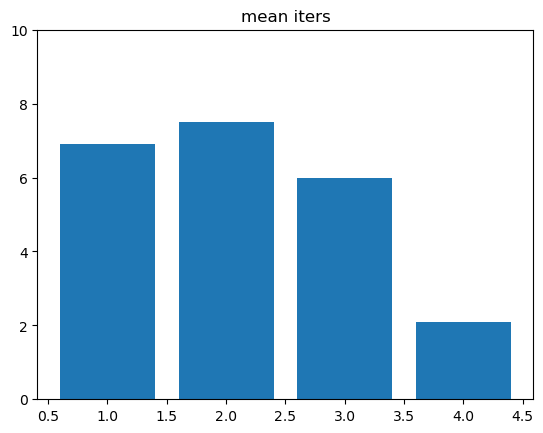

In [62]:
wp.show_res(solver, save='hyper1')
wp.bar_loc(solver, Nd, save='hyper2')

--time comparision--
newton : 2.0664007663726807
aspen : 3.802227258682251


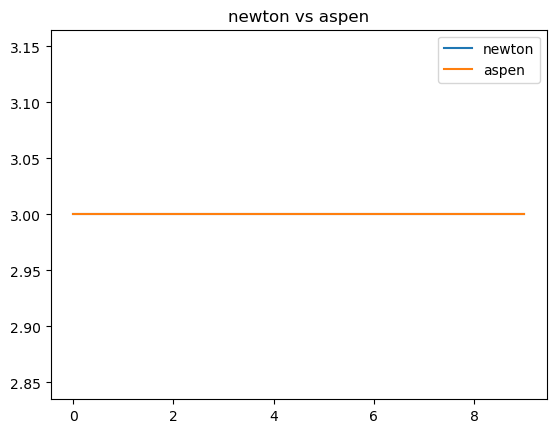

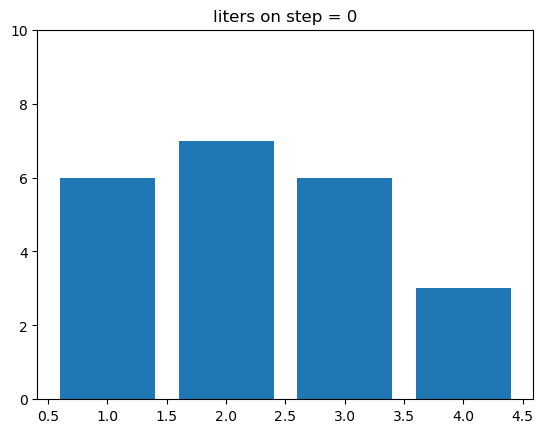

In [63]:
wp.compare([solver_n, solver], ['newton', 'aspen'], save='hyper, comp')
wp.bar_loc_step(solver, Nd, 0)

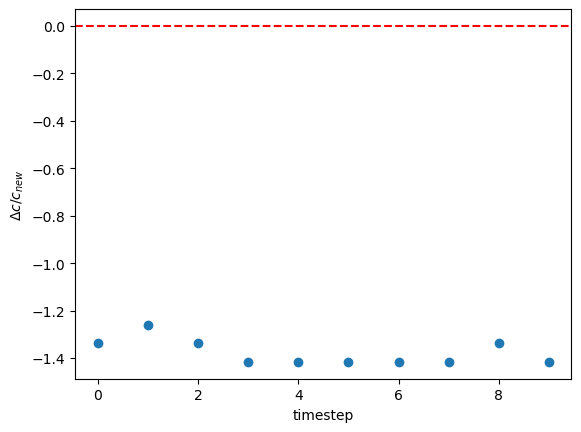

In [83]:
plt.axhline(0, linestyle='--', color='r')
plt.scatter(np.arange(Nt), (cost_new-cost_eq)/cost_new)
plt.xlabel('timestep')
plt.ylabel('$\Delta c/c_{new}$')
plt.show()

In [65]:
Nt = 10

#obrain coeficents
t_res = np.zeros((10, 4))
t_jac = np.zeros((10, 4))
t_lin = np.zeros((10, 4))

for i in range(0, 10):
    Nx = 2000 +i*200
    param ={'Nx': Nx, 'Nt' : Nt}
    # set initial condition
    x = np.linspace(0, 1, Nx)
    C = Coef(Nx, 0.5, 1, 1.2e-1, model=model)
    x0 = (np.tanh((x-0.7)*5)+1)
    x0 = x0.reshape(-1, 1)
    bd1 = x0[0]
    bd2 = x0[-1]
    
    prob = transfer(C, param)
    solver_n = fxbd_1D(param, prob)
    solver_n.setBoundary(bd1, bd2)
    nl_solver = newton(crit_abs=1e-6)
    solver_n.setSolver(nl_solver)
    solver_n.setInitial(x0)
    
    for j in range(4):
        solver_n.init_log()
        _, mes = solver_n.solve(tmax=0.1)
        sum_k = np.sum(solver_n.timelog.kn)
        t_res[i, j] = solver_n.timelog.res/((sum_k+1)*10)
        t_jac[i, j] = solver_n.timelog.jac/((sum_k)*10)
        t_lin[i, j] = solver_n.timelog.lin/((sum_k)*10)
        
    print(Nx, np.mean(t_res[i, :]), np.mean(t_jac[i, :]), np.mean(t_lin[i, :]), mes)

2000 0.005381979544957479 0.006953475773334504 0.003798985779285431 OK
2200 0.00565090122677031 0.007842618227005004 0.004424658119678497 OK
2400 0.006143917923881893 0.008879695236682892 0.005433459281921387 OK
2600 0.0060574506010328015 0.00884589970111847 0.0057600164413452145 OK
2800 0.006495935292471023 0.009739035665988924 0.006644932329654693 OK
3000 0.0068684867450169145 0.010531737804412841 0.007597213685512543 OK
3200 0.007452802431015742 0.011813875734806061 0.008688276410102846 OK
3400 0.008622391167141141 0.014406061768531798 0.010371863842010498 OK
3600 0.00898332539058867 0.014974296987056733 0.011642935574054717 OK
3800 0.00933441746802557 0.015768756270408628 0.012568024098873138 OK


In [66]:
Nx = np.arange(2000, 2000+9*200+1, 200)

from scipy.optimize import curve_fit
def func(x, a):
    return x*a

popt, pcov = curve_fit(func, Nx-2000, np.mean(t_res, axis=1)-np.mean(t_res, axis=1)[0])
print(popt, np.sqrt(pcov))
c_r = popt[0]
popt, pcov = curve_fit(func, Nx-2000, np.mean(t_jac, axis=1)-np.mean(t_jac, axis=1)[0])
print(popt, np.sqrt(pcov))
c_j = popt[0]
popt, pcov = curve_fit(func, Nx-2000, np.mean(t_lin, axis=1)-np.mean(t_lin, axis=1)[0])
print(popt, np.sqrt(pcov))
c_l = popt[0]

[2.02101925e-06] [[1.15817671e-07]]
[4.63661401e-06] [[2.15694527e-07]]
[4.51178018e-06] [[1.68290312e-07]]


In [70]:
time = np.zeros(5)
delta = np.zeros(5)
gb_iters = np.zeros((5, Nt))
lc_iters = np.zeros((5, Nd, Nt))
Cost_softloc = np.zeros((5, Nt))

Nx = 1000
Nt = 10
partion = pt.partion_equally(Nx, Nd)
x = np.linspace(0, 1, Nx)
C = Coef(Nx, 0.5, 1, 1.2e-1, model=model)
x0 = (np.tanh((x-0.7)*5)+1)
x0 = x0.reshape(-1, 1)
bd1 = x0[0]
bd2 = x0[-1]

param ={'Nx': Nx, 'Nt' : Nt}
prob = transfer(C, param)
solver = fxbd_1D(param, prob)
solver.setBoundary(bd1, bd2)
solver.setInitial(x0)

i = 0
for loc in np.logspace(-10, -8, 5):
    nl_solver = aspen(Nd, partion, crit_abs = 1e-10, crit_loc = loc)
    solver.setSolver(nl_solver)
    _, mes, time[i], delta[i] = test(solver, sample_size=4)
    gb_iters[i, :] = solver.timelog.aspen_iters
    lc_iters[i, :, :] = solver.timelog.domain_iters
    if(mes != 'OK'):
        print(i, mes)
    Cost_softloc[i, :] = Nx*( (c_r+c_l)*solver.timelog.aspen_iters+c_r
    + np.mean(solver.timelog.domain_iters, axis = 0)*(c_r+c_l+c_j))
    i += 1

test started
verdict : OK
time : 4.159 +- 0.5188
mean aspen iterations:  3.0
test started
verdict : OK
time : 4.6 +- 0.5426
mean aspen iterations:  3.0
test started
verdict : OK
time : 4.301 +- 0.4637
mean aspen iterations:  3.0
test started
verdict : OK
time : 4.165 +- 0.2912
mean aspen iterations:  3.0
test started
verdict : Not converged
time : 0.0 +- 0.0
mean aspen iterations:  0.0
4 Not converged


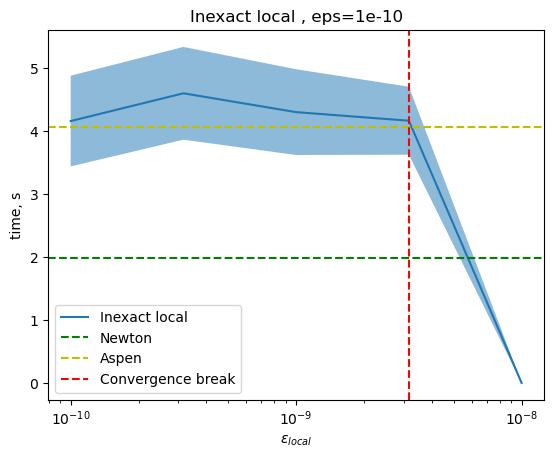

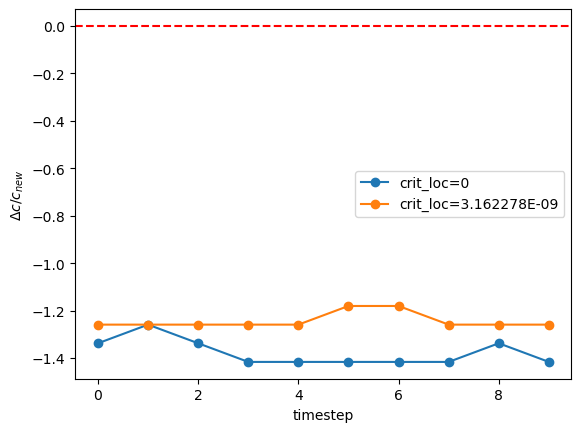

In [86]:
crit_loc = np.logspace(-10, -8, 5)

plt.title('Inexact local , eps=1e-10')
plt.ylabel('time, s')
plt.xlabel(r'$\varepsilon_{local}$')
plt.xscale('log')
plt.plot(crit_loc, time, label='Inexact local')
plt.fill_between(crit_loc, time+np.sqrt(delta),
                time-np.sqrt(delta), alpha=0.5)
plt.axhline(1.984, color='g', linestyle='--', label='Newton')
plt.axhline(4.06, color='y', linestyle='--', label='Aspen')
plt.axvline(np.logspace(-10, -8, 5)[3], color='r', linestyle='--', label='Convergence break')
plt.legend()
plt.savefig('./data/Hype0_I_time', dpi=400)
plt.show()

plt.plot(np.arange(Nt), (cost_new-cost_eq)/cost_new, marker='o', label='crit_loc=0')
plt.plot(np.arange(Nt), (cost_new-Cost_softloc[3, :])/cost_new, marker='o',
         label='crit_loc={:4E}'.format(np.logspace(-10, -8, 5)[3]))
plt.axhline(0, linestyle='--', color='r')

plt.xlabel('timestep')
plt.ylabel('$\Delta c/c_{new}$')
plt.legend()
plt.savefig('./data/hype_rel_comp_over_time_eq', dpi = 300)
plt.show()

In [92]:
Nx = 1000
Nt = 10
partion = pt.partion_equally(Nx, Nd)

param ={'Nx': Nx, 'Nt' : Nt}
prob = transfer(C, param)
solver = fxbd_1D(param, prob)
solver.setBoundary(bd1, bd2)
solver.setInitial(x0)

time = np.zeros(15)
delta = np.zeros(15)
gb_iters = np.zeros((15, Nt))
lc_iters = np.zeros((15, Nd, Nt))
Cost_softloc = np.zeros((15, Nt))

i = 0
for crit_rel in np.logspace(-15, -0.05, 15):
    nl_solver = aspen(Nd, partion, crit_abs = 1e-10, crit_rel = crit_rel)
    solver.setSolver(nl_solver)
    _, mes, time[i], delta[i] = test(solver, sample_size=4)
    gb_iters[i, :] = solver.timelog.aspen_iters
    lc_iters[i, :, :] = solver.timelog.domain_iters
    if(mes != 'OK'):
        print(i, mes)
    Cost_softloc[i, :] = Nx*( (c_r+c_l)*solver.timelog.aspen_iters+c_r
    + np.mean(solver.timelog.domain_iters, axis = 0)*(c_r+c_l+c_j))
    i += 1

test started
verdict : OK
time : 4.162 +- 0.3765
mean aspen iterations:  3.0
test started
verdict : OK
time : 3.939 +- 0.4222
mean aspen iterations:  3.0
test started
verdict : OK
time : 4.196 +- 0.205
mean aspen iterations:  3.0
test started
verdict : OK
time : 4.177 +- 0.1075
mean aspen iterations:  3.0
test started
verdict : OK
time : 4.151 +- 0.2191
mean aspen iterations:  3.0
test started
verdict : OK
time : 4.126 +- 0.2389
mean aspen iterations:  3.0
test started
verdict : OK
time : 4.205 +- 0.1861
mean aspen iterations:  3.0
test started
verdict : OK
time : 4.246 +- 0.2767
mean aspen iterations:  3.0
test started
verdict : OK
time : 4.183 +- 0.1976
mean aspen iterations:  3.0
test started
verdict : OK
time : 4.045 +- 0.1539
mean aspen iterations:  3.0
test started
verdict : OK
time : 3.942 +- 0.3343
mean aspen iterations:  3.1
test started
verdict : OK
time : 4.124 +- 0.1475
mean aspen iterations:  3.8
test started
verdict : OK
time : 3.829 +- 0.5141
mean aspen iterations:  4.0


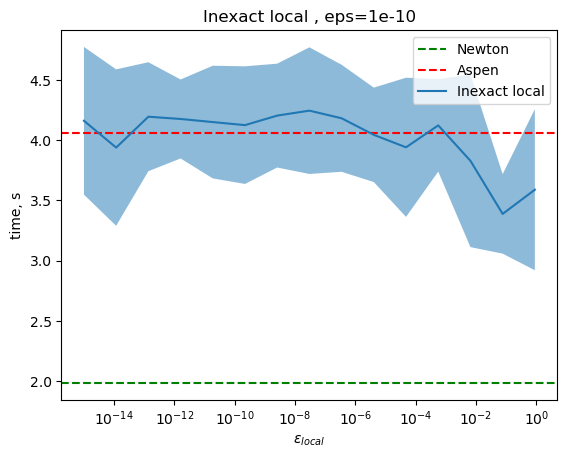

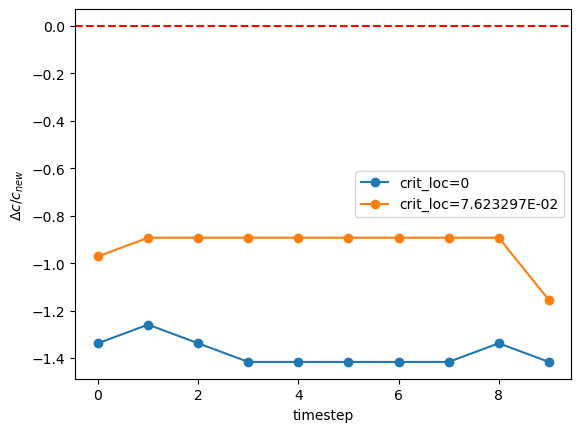

In [94]:
crit_rel = np.logspace(-15, -0.05, 15)

plt.title('Inexact local , eps=1e-10')
plt.ylabel('time, s')
plt.xlabel(r'$\varepsilon_{local}$')
plt.xscale('log')
plt.axhline(1.984, color='g', linestyle='--', label='Newton')
plt.axhline(4.06, color='r', linestyle='--', label='Aspen')
plt.plot(crit_rel, time, label='Inexact local')
plt.fill_between(crit_rel, time+np.sqrt(delta),
                time-np.sqrt(delta), alpha=0.5)
plt.savefig('./data/Hype0_I_time', dpi=400)
plt.legend()
plt.show()

plt.plot(np.arange(Nt), (cost_new-cost_eq)/cost_new, marker='o', label='crit_loc=0')
plt.plot(np.arange(Nt), (cost_new-Cost_softloc[13, :])/cost_new, marker='o',
         label='crit_loc={:4E}'.format(np.logspace(-15, -0.05, 15)[13]))
plt.axhline(0, linestyle='--', color='r')

plt.xlabel('timestep')
plt.ylabel('$\Delta c/c_{new}$')
plt.legend()
plt.savefig('./data/hype_rel_comp_over_time_eq', dpi = 300)
plt.show()